Analyze state of the union addresses. 
Data source: https://en.wikisource.org/wiki/Portal:State_of_the_Union_Speeches_by_United_States_Presidents
scrape the text of all speeches and then maybe try to find patterns of speech of each president?

https://nlp.stanford.edu/IR-book/html/htmledition/sublinear-tf-scaling-1.html 
https://www.oreilly.com/library/view/applied-text-analysis/9781491963036/ch04.html 

## Setup

In [6]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import urllib.request
import re

from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.corpora.dictionary import Dictionary
import gensim
from gensim import corpora, models
import spacy
import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Data source we are going to scrape for results
data_url = 'https://en.wikisource.org/wiki/Portal:State_of_the_Union_Speeches_by_United_States_Presidents'

link_list = []

# extract the text of a speech from a URL
# text is extracted in a list of paragraphs (strings) for each speech
def get_speech(url):
    return([ p.text.strip() for p in BeautifulSoup(urllib.request.urlopen(url)).find_all("p") if \
             'This work is in the public domain in the United States because it is a work of the United States federal government' \
             not in p.text.strip()])

# Make a frequency count by distinct values of 
# column(s) listed in 'groupbyvars'
# Returns pandas dataframe
def tidy_count(df,groupbyvars):
    return(df.groupby(groupbyvars).size().reset_index().\
        rename(columns={0: "n"}).sort_values('n',ascending=False).reset_index(drop=True))

## Web Scraping

In [7]:
resp = urllib.request.urlopen(data_url)
soup = BeautifulSoup(resp, from_encoding=resp.info().get_param('charset'))

# Get all links to state of the union addresses from 
for link in soup.find_all('a', href=True):
    if "union_address" in link['href'].lower() or "union_speech" in link['href'].lower() \
        and "portal" not in link['href'].lower() and "#" not in link['href'].lower():
        link_list.append(link['href'])

# Note that I am storing these speeches as lists of paragraphs (strings) for readability
speeches = [get_speech('https://en.wikisource.org' + link) for link in link_list]
# Extract presidents names from link text
presidents = [ link.replace('%','/').split('/')[2].replace('_',' ') for link in link_list ]

# Extract state of the union text entries so we can extract the date
sou_entries = []
for item in soup.find_all('li'):
    if 'union' in item.text.strip().lower() and '(' in  item.text.strip().lower():
        sou_entries.append(item.text.strip())

speeches_pd = pd.DataFrame({
                'president' : presidents,
                'speech' : speeches,
                'year' : [int(re.findall('\d+',item)[1]) for item in sou_entries ]} )
        

In [8]:
speeches_pd.sample(n=5)

,president,speech,year
134,Calvin Coolidge,[Since the close of the last Congress the Nati...,1923
169,Dwight D. Eisenhower,"[Mr. President, Mr. Speaker, Members of the 85...",1958
81,Ulysses S. Grant,"[To the Senate and House of Representatives:, ...",1870
0,George Washington,[I embrace with great satisfaction the opportu...,1790
198,Ronald Reagan,"[Mr. Speaker, Mr. President, distinguished mem...",1986


## Preprocessing

Clean text (remove stop words, convert to lower case, remove non-alphabetic text, and lemmatize

In [9]:
nlp = spacy.load('en', disable=['parser', 'ner']) # disabling the parser makes it run faster
#nlp = spacy.load('en_core_web_lg',disable=['parser', 'ner'])

# Preprocess pipeline with spacy. 
def spacy_preprocess(text): 
    text_out = []
    for token in nlp(text.lower()):
        # Get rid of stop words and non-alphanumeric
        if not token.is_stop and token.is_alpha and len(token)>1:
            lemma = token.lemma_
            if lemma != '-PRON-':
                text_out.append(lemma)
            else:
                text_out.append(token.text)            
    return(text_out)

In [10]:
# Case sensitivity matters for stop-words for some reason
# So we need to convert all text to lowercase before
# letting spacy see it (as done in above function)
for token in nlp('The the'):
    print(not token.is_stop)

True
False


In [11]:
# test spacy preprocessing
spacy_preprocess('The dog ran into Bob beCause he saw 234 squirrels under VAU15')

['dog', 'run', 'bob', 'see', 'squirrel']

In [12]:
# Each speech is stored as a list of paragraph strings. 
# Here we join the paragraphs into a single speech string
speech_list = [" ".join(speech) for speech in speeches_pd['speech'].tolist() ]

## Pre-process and tokenize our speeches
start = time.time()
tokens = [spacy_preprocess(speech) for \
          speech in speech_list ]
print('Preprocessing time elapsed: ' + str(time.time()-start))

Preprocessing time elapsed: 100.60255813598633


## Gensim Topic Modeling

In [13]:
# create dictionary and corpus objects for gensim topic modeling
common_dictionary = Dictionary(tokens)
gensim_corpus = [common_dictionary.doc2bow(doc) for doc in tokens]

In [14]:
start = time.time()
gensimLDA = gensim.models.ldamodel.LdaModel(gensim_corpus,num_topics=12,
        random_state=42, id2word=common_dictionary,passes=10)
print('Gensim LDA training time: ' + str(time.time()-start))

Gensim LDA training time: 67.68750023841858


In [15]:
# Print the words in each gensim topic without probabilties
# to show probabilites, just use the gensimModel.show_topics() function
def print_gensim_topics(gensimModel,n_words):
    gensim_topic_list = gensimModel.print_topics(num_words=n_words)
    for n, topic in enumerate(gensim_topic_list):
        # Grab words that are in double quotes (ie. strip out probabilities)
        print('topic ' + str(n) + ": " + " ".join(re.findall(r'"(.*?)"', topic[1])))

print_gensim_topics(gensimLDA,18)
#gensimLDA.show_topics()

topic 0: government man state law country nation american people great good united power year right public case work matter
topic 1: government state united year congress nation country time great people shall law american good act war program interest
topic 2: american year america child work people new tonight school nation family good congress world help country ask know
topic 3: year american people new nation world america government work congress program state need time good help war country
topic 4: government year congress federal country state public increase department national service law expenditure work system large need present
topic 5: state government united congress great country public power war people constitution year law time present act duty right
topic 6: year state government congress people new work nation american country time great child united law america act need
topic 7: state year united government american nation law country congress people new work grea

In [16]:
doc_top_proportions = [ gensimLDA.get_document_topics(doc,minimum_probability=0) for doc in gensim_corpus ]
doc_top_probs = pd.DataFrame([[prob for (topic, prob) in prob_tuple] for prob_tuple in doc_top_proportions])
doc_top_probs['MostCommonTopic'] = doc_top_probs.idxmax(axis=1)
doc_top_probs[['year','president']] = speeches_pd[['year','president']]

Topic 10 seems to be related to war and peace, plot the prevalence of the topic

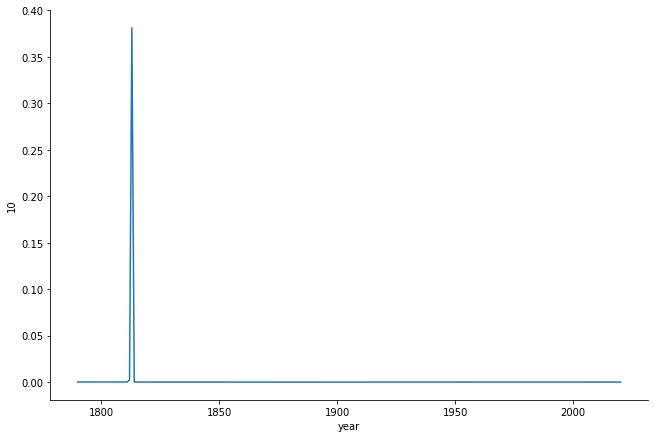

In [17]:
sns.relplot(x="year",y=10, data=doc_top_probs,kind="line",height=6,aspect=1.5)
#plt.xlim(1995,2018)

In [18]:
tidy_count(doc_top_probs,'MostCommonTopic')

,MostCommonTopic,n
0,8,95
1,3,63
2,9,31
3,5,20
4,2,12
5,4,9
6,0,1
7,10,1
8,11,1


In [19]:
doc_top_probs.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,MostCommonTopic,year,president
50,0.000015,0.000015,0.000015,0.000015,0.000015,0.818892,0.000015,0.000015,0.180957,0.000015,0.000015,0.000015,5,1839,Martin Van Buren
154,0.000056,0.000056,0.000056,0.685221,0.000056,0.059241,0.000056,0.000056,0.002226,0.252861,0.000056,0.000056,3,1944,Franklin Delano Roosevelt
67,0.000019,0.000019,0.000019,0.000019,0.000019,0.990903,0.000019,0.000019,0.008912,0.000019,0.000019,0.000019,5,1856,Franklin Pierce
161,0.000048,0.000048,0.000048,0.443746,0.000048,0.000048,0.000048,0.000048,0.000048,0.555775,0.000048,0.000048,9,1951,Harry S. Truman
26,0.000062,0.000062,0.000062,0.000062,0.000062,0.271553,0.000062,0.000062,0.727831,0.000062,0.000062,0.000062,8,1815,James Madison


In [21]:
#doc_top_probs.drop('MostCommonTopic', axis=1).idxmax(axis=0)

## SkLearn Topic Modeling

In [22]:
# Vectorize
#tvec = TfidfVectorizer(tokenizer=None,analyzer='word',
#                        max_df=0.95, min_df=2,
#                        ngram_range=(1,1),max_features=10000)

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2)
                        #        max_features=10000)
tf = pd.DataFrame(tf_vectorizer.fit_transform([" ".join(doc) for doc in tokens]).toarray(),
                     columns  = tf_vectorizer.get_feature_names())

In [23]:
tf.shape

(233, 11440)

In [24]:
## LDA Topic Modeling
speech_lda = LatentDirichletAllocation(n_components=8,
                                       random_state=42,
                                    #   evaluate_every=0.5, # eval perplexity
                                    #   perp_tol=0.05,
                                       max_iter=30,
                                learning_method='online'
                                      )
start = time.time()
speech_lda.fit(tf) # fit model
print('Sklearn LDA training time: ' + str(time.time()-start))


Sklearn LDA training time: 49.22464942932129


In [25]:
# Print the top words for topics in the topic model
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic %d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()    

print_top_words(speech_lda, tf.columns.values, 20)

Topic 0: present increase department service general report subject american large duty secretary result citizen condition foreign land shall treaty legislation recommend
Topic 1: american work increase america need system world present business citizen department service result report subject program job tax large foreign
Topic 2: present citizen duty general secretary service report necessary treaty subject increase number condition department large shall american work purpose foreign
Topic 3: american world america work program need help federal tax economic security job increase million know child economy free let life
Topic 4: present work increase man duty treaty american department general shall subject service result legislation question policy office attention land commerce
Topic 5: man work need business condition american labor present service necessary matter far possible way increase corporation action shall large come
Topic 6: present citizen treaty duty subject general s

In [26]:
# % makeup of each document by topic
doc_topic = pd.DataFrame(speech_lda.transform(tf),
                        columns=list(range(0,(speech_lda.n_components))))

# What was the most common topic in each document?
doc_topic['MostCommonTopic'] = doc_topic.idxmax(axis=1)
doc_topic[['year','president']] = speeches_pd[['year','president']]

In [27]:
tidy_count(doc_topic,'MostCommonTopic')

,MostCommonTopic,n
0,3,90
1,7,70
2,0,58
3,5,15


In [28]:
# In which document did each topic most commonly occur?
doc_topic.drop('president',axis=1).idxmax(axis=0)

0                  105
1                    0
2                    0
3                  212
4                    0
5                  119
6                    0
7                   35
MostCommonTopic      0
year               232
dtype: int64

In [29]:
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)

In [30]:
president_topic = doc_topic.drop(['MostCommonTopic','year'],axis=1).groupby('president').agg('mean')

In [31]:
president_topic.sample(15).style.background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7
president,,,,,,,,
Bill Clinton,0.000043,0.000043,0.000043,0.999701,0.000043,0.000043,0.000043,0.000043
George Washington,0.005752,0.000183,0.000183,0.000184,0.000183,0.001398,0.000183,0.991933
George W. Bush,0.000059,0.000058,0.000058,0.999591,0.000058,0.000059,0.000058,0.000059
John F. Kennedy,0.064080,0.000052,0.000052,0.935608,0.000052,0.000052,0.000052,0.000052
Lyndon Baines Johnson,0.041676,0.000072,0.000072,0.948069,0.000072,0.009895,0.000072,0.000072
Calvin Coolidge,0.540298,0.000038,0.000038,0.187164,0.000038,0.272346,0.000038,0.000039
Abraham Lincoln,0.744337,0.000052,0.000052,0.002066,0.000052,0.000052,0.000052,0.253338
Donald Trump,0.000057,0.000057,0.000057,0.999604,0.000057,0.000057,0.000057,0.000057
John Adams,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.000198,0.998614


In [32]:
#doc_topic.style.background_gradient(cmap=cm)

Topic 7 seems to be related to economic programs, let's plot the prevalence of that topic over time

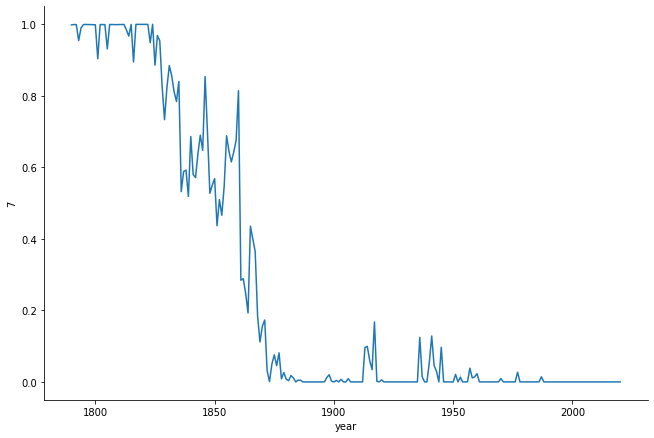

In [33]:
sns.relplot(x="year",y=7,data=doc_topic,kind="line",height=6,aspect=1.5)
#plt.xlim(1900,2000)

## Predict Year of Address

In [34]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X = doc_topic.drop(['MostCommonTopic','president','year'],axis=1)
y = doc_topic['year']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

In [35]:
LASSOreg = LassoCV(cv=5, random_state=0).fit(X_train, y_train)

# Print train and test R^2
print(LASSOreg.score(X_train,y_train))
print(LASSOreg.score(X_test,y_test))

0.9622668917308718
0.9526408586778637


In [36]:
mean_absolute_error(LASSOreg.predict(X_test),y_test)

11.25343909476925

In [37]:
# Obtain pandas dataframe of model coefficients sorted by value
# To do : sort by absolute value
def obtain_coefficients(model):
    coefficients = pd.DataFrame(model.coef_.T)
    coefficients.insert(0,'',list(X.columns.values))
    coefficients.columns = ['term','coefficient']
    coefficients.sort_values(by='coefficient',ascending=False,inplace=True)
    return(coefficients)

obtain_coefficients(LASSOreg)

,term,coefficient
3,3,96.730997
5,5,15.981584
0,0,-0.000000
1,1,-0.000000
2,2,-0.000000
4,4,-0.000000
6,6,-0.000000
7,7,-77.997459


According to the model, topic 4 is associated with more recent addresses while topics 1 and 0 are associated with older addresses. 
Topic 4 has personal terms such as 'child','family', and 'job' while topics 0 and 1 seem to be more associated with legislation and policy.

## Sentiment Analysis

In [38]:
sentiments = [TextBlob(text).sentiment for text in speech_list ] 

speeches_pd['polarity'] = [ i[0] for i in sentiments]
speeches_pd['subjectivity'] = [ i[1] for i in sentiments]

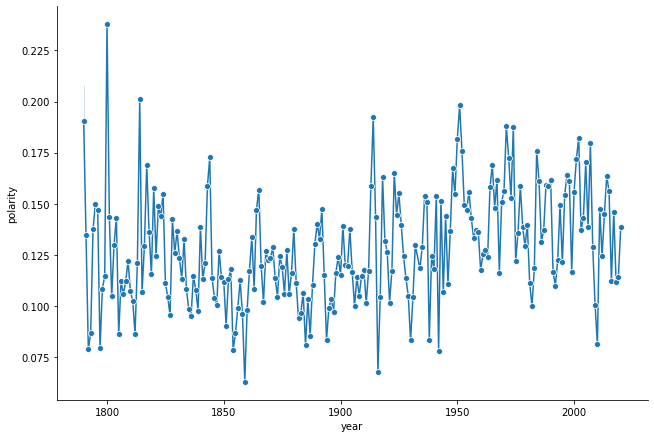

In [39]:
sns.relplot(x="year", y="polarity", data=speeches_pd,kind="line",height=6, aspect=1.5, marker="o")